# 读取tsv文件，查看结构

In [2]:
import pandas as pd

df = pd.read_csv('train-0000.tsv', sep='\t', header=None)
df.head(2)

FileNotFoundError: [Errno 2] No such file or directory: 'train-0000.tsv'

In [ ]:
dict_format = df.iloc[10, 1]
dict_format

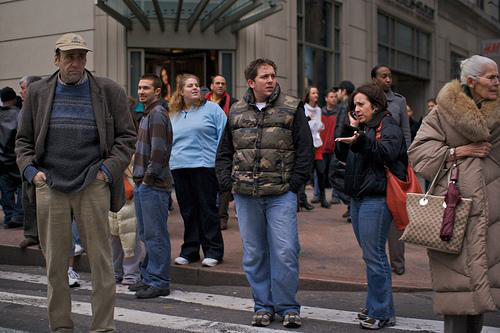

In [44]:
import base64
from PIL import Image
from io import BytesIO
image_data = base64.b64decode(dict_format["image"])
# 将解码后的数据转换为PIL图像
image = Image.open(BytesIO(image_data))
image

In [45]:
dict_format["caption"]

'Several people , of various ages and clothing styles , stand near a sidewalk .'

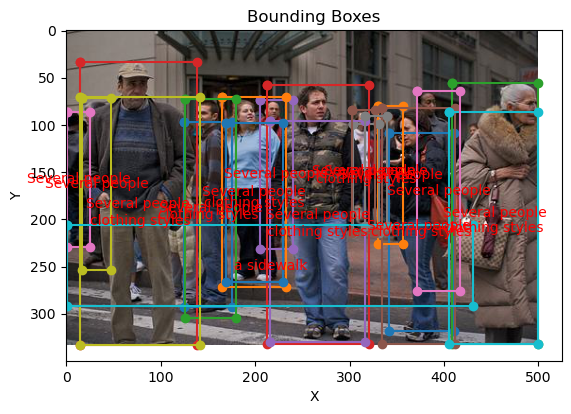

In [46]:
fig, ax = plt.subplots()
ax.imshow(image)
for i in dict_format["annos"]:
    # 获取bbox的左上角坐标和宽高
    x, y, w, h = i['bbox']
    # 计算四个角点的坐标
    bbox_coords = [
        (x, y),  # 左上角
        (x + w, y),  # 右上角
        (x + w, y + h),  # 右下角
        (x, y + h)   # 左下角
    ]
    
    
    # 获取x和y坐标列表，并闭合bounding box
    x_coords = [point[0] for point in bbox_coords] + [bbox_coords[0][0]]
    y_coords = [point[1] for point in bbox_coords] + [bbox_coords[0][1]]
    
    # 画bounding box
    ax.plot(x_coords, y_coords, marker='o')
    # 计算中心点坐标
    center_x = x + w / 2
    center_y = y + h / 2
    
    # 在中心点写文本
    ax.text(center_x, center_y, dict_format["caption"][i["tokens_positive"][0][0]:i["tokens_positive"][0][1]], color='red', ha='center', va='center')

# 设置图表的标题和坐标轴标签
ax.set_title('Bounding Boxes')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 显示图表
plt.show()
    


# 导入库和函数

In [6]:
import os
from PIL import Image
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
import base64
from io import BytesIO
import json
import torch
import numpy as np
from transformers import pipeline
from PIL import Image, ImageDraw
from shapely.geometry import Point, Polygon
from tqdm import tqdm

def get_bounding_box(polygon):
    poly = Polygon(polygon)
    min_x, min_y, max_x, max_y = poly.bounds
    w = max_x - min_x
    h = max_y - min_y
    return [min_x, min_y, w, h]



def get_annos(xml_dict):
    tree = ET.parse(xml_dict)
    root = tree.getroot()

    # 创建一个字典来存储物品和其坐标
    items = {}

    # 遍历所有物品节点
    for obj in root.findall('object'):
        name = obj.find('name').text.strip()
        polygon = obj.find('polygon')
        points = []

        # 提取多边形的所有点坐标
        for pt in polygon.findall('pt'):
            x = int(pt.find('x').text)
            y = int(pt.find('y').text)
            points.append((x, y))

        # 将物品名称和对应的点坐标添加到字典中
        if name not in items:
            items[name] = []
        items[name].append(points)
        
    return items

def showimage(image, annos, save_path):
    plt.imshow(image)
    for item, boxes in annos.items():
        # 随机选择颜色
        color = (random.random(), random.random(), random.random())
        for box in boxes:
            x, y, w, h = box  # 获取四个值

            # 定义矩形的四个顶点
            rectangle = [
                (x, y),
                (x + w, y),
                (x + w, y + h),
                (x, y + h)
            ]

            # 解压坐标列表
            rx, ry = zip(*rectangle)
            plt.fill(rx, ry, color=color, alpha=0.3, label=item)

            # 在矩形的中心点添加物品名称
            centroid_x = x + w / 2
            centroid_y = y + h / 2
            plt.text(centroid_x, centroid_y, item, ha='center', va='center', fontsize=8, color=color)

    # 显示图形
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('')
    #plt.show()
    plt.savefig(save_path)
    plt.close()
    

def encode_pillow_to_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode('utf-8')
    
    
def get_captions(annos,location):
    x = [i for i in annos.keys()]
    x = [location] + x 
    return ",".join(x)

def encode_tensor_as_string(arr):
    if type(arr) != np.ndarray:
        arr = arr.data.cpu().numpy()
    return base64.b64encode(arr.tobytes()).decode('utf-8')

def replace_single_quotes_in_tsv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    modified_lines = [line.replace("'", '"') for line in lines]

    with open(output_file, 'w', encoding='utf-8') as file:
        file.writelines(modified_lines)
        
        


def average_gray_in_polygon(image, polygon_points):
    gray_array = np.array(image, dtype=np.float64)

    # 创建Shapely的多边形对象
    polygon = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = map(int, polygon.bounds)

    # 用于计算平均值的变量
    total_gray = 0
    count = 0
    
    # 创建与图像大小相同的掩码数组，初始化为0
    mask = np.zeros(gray_array.shape, dtype=np.uint8)
    

    # 遍历图片的每个像素
    for x in range(min_x, min(max_x + 1, gray_array.shape[1])):
        for y in range(min_y, min(max_y + 1, gray_array.shape[0])):
            point = Point(x, y)
            if polygon.contains(point):
                total_gray += gray_array[y, x]
                count += 1
                mask[y, x] = 1
                
    if count == 0:
        return -1, mask
                
    # 计算平均值            
    avg_gray = total_gray // count
    return avg_gray, mask

def get_annos_list_v1(annos,caption,object_id,image_id,depth_img):
    depth_info = {}
    rectangles = {}
    for item, polygons in annos.items():
        all_rect = []
        all_avg_dep = []
        all_mask = []
        for polygon in polygons:
            avg_dep, mask = average_gray_in_polygon(depth_img.convert('L'), polygon)  
            if avg_dep == -1:
                continue
            rect = get_bounding_box(polygon)
            all_avg_dep.append(avg_dep)
            all_mask.append(mask)
            all_rect.append(rect)
        if len(all_rect) != 0:
            rectangles[item] = all_rect
            depth_info[item] = [all_avg_dep, all_mask]
            
    annos_list = []
    for item, boxes in rectangles.items():
        start_index = caption.find(item)
        end_index = start_index + len(item)
        for i in range(len(boxes)):
            annos = {
                "category_id": 1,
                "id": object_id,
                "bbox": boxes[i],
                "tokens_positive":[[start_index,end_index]],
                "data_id": image_id,
                "depth_info": depth_info[item][0][i],
                "depth_mask": encode_tensor_as_string(torch.tensor(depth_info[item][1][i]))
            }
            object_id += 1
            annos_list.append(annos)
            
    return annos_list, object_id, rectangles


def get_annos_list_v2(annos,caption,object_id,image_id,depth_img):
    rectangles = {}
    for item, polygons in annos.items():
        all_rect = []
        for polygon in polygons:
            rect = get_bounding_box(polygon)
            all_rect.append(rect)
        rectangles[item] = all_rect
            
    annos_list = []
    for item, boxes in rectangles.items():
        start_index = caption.find(item)
        end_index = start_index + len(item)
        for i in range(len(boxes)):
            annos = {
                "category_id": 1,
                "id": object_id,
                "bbox": boxes[i],
                "tokens_positive":[[start_index,end_index]],
                "data_id": image_id,
                "depth_info": average_gray_in_rect(depth_img.convert('L') , boxes[i])
            }
            object_id += 1
            annos_list.append(annos)
            
    return annos_list, object_id, rectangles



def average_gray_in_rect(image, boxes):
    x, y, w, h = boxes
    img_array = np.array(image)
    roi = img_array[int(y):int(y+h), int(x):int(x+w)]
    avg_gray = np.mean(roi, axis=(0, 1))
    return avg_gray

# 初步处理，不带clip feature

In [7]:
####修改参数######
directory_path_annos = r"D:\project\gligen dataset\indoorCVPR_09annotations\Annotations"
directory_path_image = r'D:\project\gligen dataset\indoorCVPR_09\Images'
####修改参数######
image_id = 0
object_id = 0
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf", device=0)
all_image=[]

locations = os.listdir(directory_path_annos)
for location in tqdm(locations, desc="Processing locations"):
    annos_folder_path = os.path.join(directory_path_annos, location)
    image_folder_path = os.path.join(directory_path_image, location)
    filenames = os.listdir(annos_folder_path)
    for filename in tqdm(filenames, desc=f"Processing {location}", leave=False):
        annos_path = os.path.join(annos_folder_path, filename)
        image_path = os.path.join(image_folder_path, filename[:-4]+".jpg")
        
        try:
            annos = get_annos(annos_path)
            image = Image.open(image_path)
            encoded_image = encode_pillow_to_base64(image)
        except Exception as e:
            print(f"Error opening image {image_path}: {e}")
            continue
        
        caption = get_captions(annos,location)
        depth_img = pipe(image)["depth"]
        annos_list, object_id, rectangles = get_annos_list_v2(annos,caption,object_id,image_id,depth_img)
        
        #showimage(image, rectangles, os.path.join(r"D:\project\gligen dataset\test",filename[:-4]+".jpg"))
        
        image_dict = {
            "data_id": image_id,
            "image": encoded_image,
            "file_name": image_path,
            "caption": caption,
            "annos": annos_list
            }
        image_id += 1
        all_image.append(image_dict)
        
        
        
#with open('training_data.json', 'w') as f:
#    json.dump(all_image, f)

Processing locations:   0%|                                                                     | 0/67 [00:09<?, ?it/s]


KeyboardInterrupt: 

In [335]:
with open('training_data.json', 'w') as f:
    json.dump(all_image, f)

# 二次处理，加入clip feature并整合成最终tsv文件

In [336]:
with open('training_data.json', 'r') as f:
    all_image = json.load(f)

In [339]:

# 指定输入和输出文件路径
input_file = 'output.tsv'
output_file = 'outputfinal.tsv'

####修改参数######
folder = r'D:\project\gligen dataset\out'
####修改参数######
for data in tqdm(all_image, desc="Processing images"):
    for obj in data["annos"]:
        text_before_path = os.path.join(folder, 'text_features_before', str(obj["id"]))
        text_embedding_before = torch.load(text_before_path)
        obj["text_embedding_before"] = encode_tensor_as_string(text_embedding_before)
        
        text_after_path = os.path.join(folder, 'text_features_after', str(obj["id"]))
        text_embedding_after = torch.load(text_after_path)
        obj["text_embedding_after"] = encode_tensor_as_string(text_embedding_after)
        
        image_before_path = os.path.join(folder, 'image_features_before', str(obj["id"]))
        image_embedding_before = torch.load(image_before_path)
        obj["image_embedding_before"] = encode_tensor_as_string(image_embedding_before)
        
        image_after_path = os.path.join(folder, 'image_features_after', str(obj["id"]))
        text_embedding_after = torch.load(image_after_path)
        obj["image_embedding_after"] = encode_tensor_as_string(text_embedding_after)
    
import pandas as pd
df = pd.DataFrame({'0': range(len(all_image)), '1': all_image})
df = df.drop(1229)
df = df.drop(1824)
df = df.drop(1826)
df = df.drop(1928)
df = df.drop(2084)
df = df.drop(2231)
df = df.drop(2237)
df = df.drop(2409)
df = df.drop(2415)
df.to_csv('output.tsv', sep='\t', index=False, header=False)


input_file = 'output.tsv'
output_file = r'D:\project\GLIGEN\DATA\dataset\train-00.tsv'
replace_single_quotes_in_tsv(input_file, output_file)

Processing images: 100%|██████████████████████████████████████████████████████████| 2733/2733 [00:23<00:00, 117.05it/s]


# 深度图获取

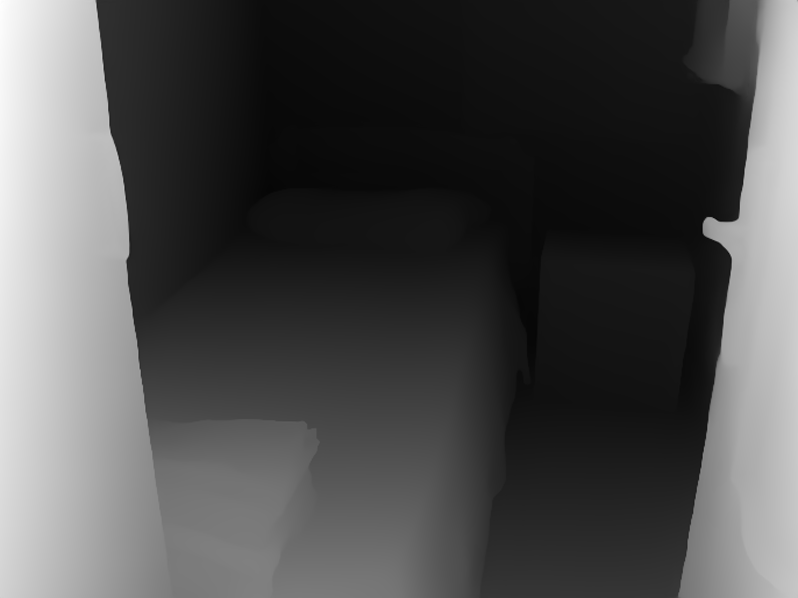

In [9]:
from transformers import pipeline
from PIL import Image

pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf", device=0)
image = Image.open(r'D:\project\gligen dataset\indoorCVPR_09\Images\bedroom\007330543b.jpg')
depth = pipe(image)["depth"]

depth

# 查看数据集分割情况

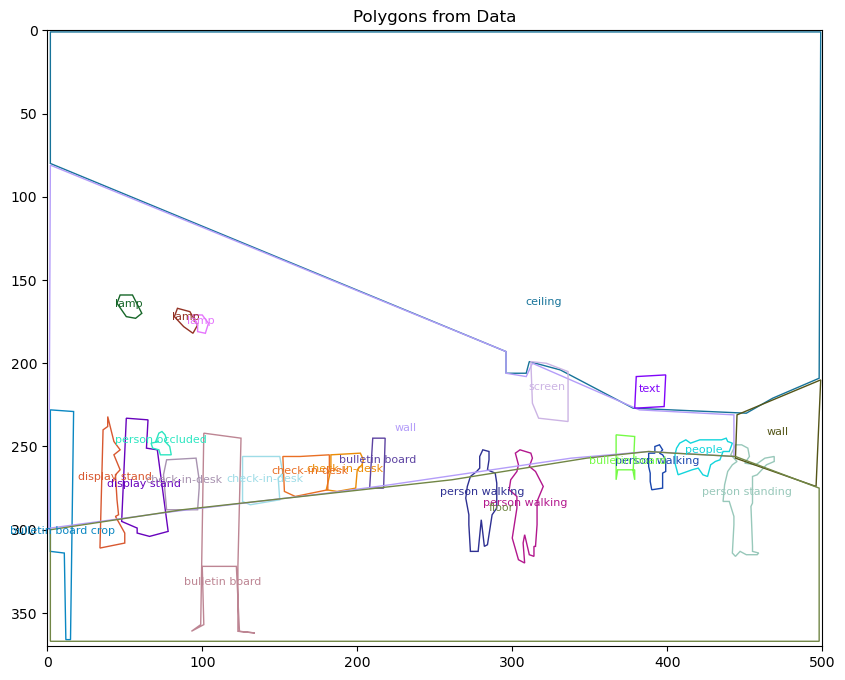

In [182]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_xlim(0, 500)
ax.set_ylim(0, 370)

for key, polygons in annos.items():
    for polygon in polygons:
        color = (random.random(), random.random(), random.random())
        poly = patches.Polygon(polygon, closed=True, fill=None, edgecolor=color)
        ax.add_patch(poly)
        
        xs, ys = zip(*polygon)
        center_x = sum(xs) / len(xs)
        center_y = sum(ys) / len(ys)
        
        ax.text(center_x, center_y, key, color=color, fontsize=8, ha='center')

# 设置标题和显示图像
plt.title('Polygons from Data')
plt.gca().invert_yaxis()
plt.show()

# 清理有问题的数据

In [340]:
import csv
import pandas as pd
import json

tsv_file = r'D:\project\GLIGEN\DATA\dataset\train-00.tsv'

df = pd.read_csv(tsv_file, sep='\t',header=None)

for index, row in df.iterrows():
    try:
        json_data = json.loads(row[1])
    except json.JSONDecodeError as e:
        print(index)

In [25]:
objects = all_image[0]["caption"].split(',')
objects

'airport_inside,ceiling,person walking,person standing,bulletin board,display stand,check-in-desk,bulletin board crop,person occluded,wall,screen,text,people,floor,lamp'

# 随机检查数据是否有效

In [18]:
random_number = random.randint(0, len(all_image))

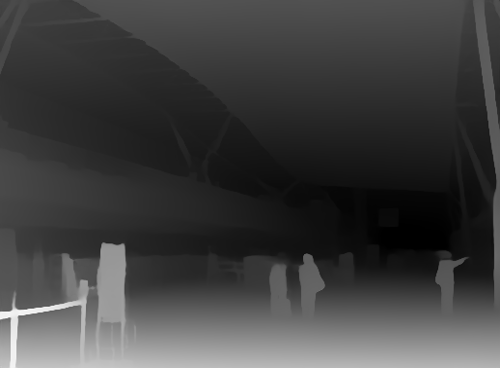

In [19]:
image_data = base64.b64decode(all_image[random_number]["image"])
# 将解码后的数据转换为PIL图像
image = Image.open(BytesIO(image_data))
pipe(image)["depth"]

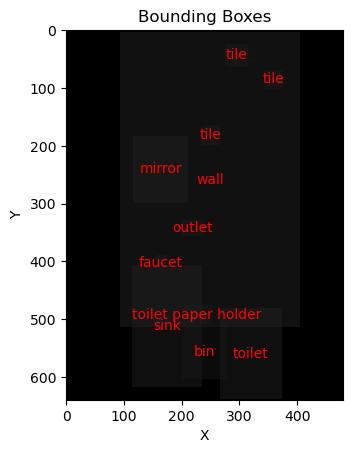

In [332]:
fig, ax = plt.subplots()
ax.imshow(Image.fromarray(np.zeros_like(np.array(image))))

for i in all_image[random_number]["annos"]:
    # 获取bbox的左上角坐标和宽高
    x, y, w, h = i['bbox']
    
    # 计算中心点坐标
    center_x = x + w / 2
    center_y = y + h / 2
    
    # 获取灰度值
    depth_info = i["depth_info"]  # 假设这个值是0到1之间的浮点数或0到255之间的整数
    
    
    # 创建矩形补丁并添加到轴中
    rect = patches.Rectangle((x, y), w, h, linewidth=0, edgecolor='blue', facecolor=str(depth_info/ 255.0), alpha=0.5)
    ax.add_patch(rect)
    
    # 在中心点写文本
    caption_text = all_image[random_number]["caption"][i["tokens_positive"][0][0]:i["tokens_positive"][0][1]]
    ax.text(center_x, center_y, caption_text, color='red', ha='center', va='center')

# 设置图表的标题和坐标轴标签
ax.set_title('Bounding Boxes')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 显示图表
plt.show()

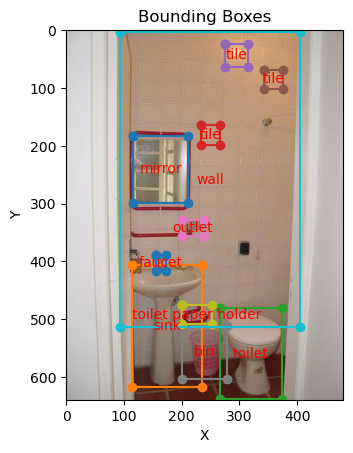

In [331]:
fig, ax = plt.subplots()
ax.imshow(image)
for i in all_image[random_number]["annos"]:
    # 获取bbox的左上角坐标和宽高
    x, y, w, h = i['bbox']
    # 计算四个角点的坐标
    bbox_coords = [
        (x, y),  # 左上角
        (x + w, y),  # 右上角
        (x + w, y + h),  # 右下角
        (x, y + h)   # 左下角
    ]
    
    
    # 获取x和y坐标列表，并闭合bounding box
    x_coords = [point[0] for point in bbox_coords] + [bbox_coords[0][0]]
    y_coords = [point[1] for point in bbox_coords] + [bbox_coords[0][1]]
    
    # 画bounding box
    ax.plot(x_coords, y_coords, marker='o')
    # 计算中心点坐标
    center_x = x + w / 2
    center_y = y + h / 2
    
    # 在中心点写文本
    ax.text(center_x, center_y, all_image[random_number]["caption"][i["tokens_positive"][0][0]:i["tokens_positive"][0][1]], color='red', ha='center', va='center')

# 设置图表的标题和坐标轴标签
ax.set_title('Bounding Boxes')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# 显示图表
plt.show()

# 其他

In [313]:
sorted_annos = sorted(all_image[random_number]["annos"], key=lambda x: x['depth_info'])
base_array = np.zeros_like(sorted_annos[0]["depth_mask"])
for index, data in enumerate(sorted_annos):
    depth_mask = data["depth_mask"]
    depth_info = data["depth_info"]
    filled_matrix = np.where(depth_mask == 1, depth_info, 0)
    non_zero_indices = filled_matrix != 0
    base_array[non_zero_indices] = filled_matrix[non_zero_indices]
    
Image.fromarray(base_array)

KeyError: 'depth_mask'